In [6]:
#Displays %age and counts line plots of a single question from Food for You
#Contains code to calculate errors and confidence intervals by bootstrap
#Code written by Lorena Garcia-Perez & James Doherty

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import resample

pd.set_option('display.max_rows', None)

Saving withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx to withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx
Saving Food+and+You+Waves+1-5+Data (3).csv to Food+and+You+Waves+1-5+Data (3).csv


In [39]:
# Create a dictionary of question names
questions_dict = pd.read_excel('withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx', 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict() #OR: dict(zip(questions_dict.Variable, questions_dict.Label))
print(questions_dict)

# Create a nested dictionary of answer names
answers_dict = pd.read_excel('withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx', 'Values')
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
print(answers_dict)

{'SerialNo': 'Serial Number', 'RespSex': 'Gender', 'age_dv': '(D) Age of respondent in bands: W4-5', 'bhhsize2': '(D) Household size (4 categories)', 'below6': '(D) Children under 6 in household', 'below16': '(D) Children under 16 in household', 'marstat2': '(D) Marital status', 'hhdinc': '(D) Household income', 'workstat2': '(D) Working Status (3 categories)', 'region_dv': '(D) Region', 'religion_dv': '(D) Religion', 'wimd_2014_quintile': 'Wales - WIMD 2015 - Overall rank - QUINTILE', 'nimd_2010_quintile': 'Northern Ireland - NIMD 2010 - QUINTILE', 'nimd2017_quintile': 'Northern Ireland - NIMD 2017 - Overall rank - QUINTILE', 'UrbanRuralInd': '(D) Net Urban-Rural Classification', 'surveyyear': '(D) Survey Year', 'country_dv': '(D) Country', 'psu_dv': 'primary sample unit', 'stratum_all_dv': 'Strata', 'combinedW1_5weight': '(D) Combined all countries calibration weight core+boost+extra (scaled to countries %)', 'countryW1_5weight': '(D) Combined all countries calibration weight core+bo

In [40]:
#Read in data from F&U and deal with null values
data = pd.read_csv('Food+and+You+Waves+1-5+Data (3).csv')
data = pd.DataFrame(data)

data = data.replace([-9, -8, -1, 98], np.nan)
cols = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
        'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
data[cols] = data[cols].replace([5], np.nan)

print(data.shape)

(14541, 502)


In [0]:
# Custom function for plotting.
# It specifies the % number on top.
# I double checked it handles well preceding NaNs values (sns.pointplot doesn't handle this well)
def f(x,y, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Define a wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

CI1 = 1.5702905158821931 1.5990279027935521
CI2 = (1.5702905158821931, 1.5990279027935521)
CI3 = (1.5702905158821931, 1.5990279027935521)
1 sigma error =  0.00730682002841424
2 sigma error =  0.01461364005682848
Bootstrapped CI =  1.5700299019427546 1.5992571820564114


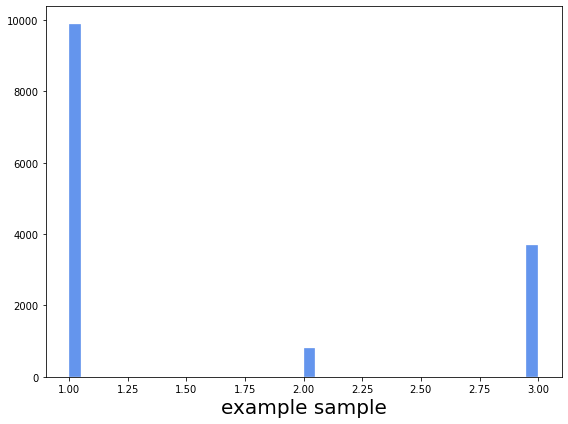

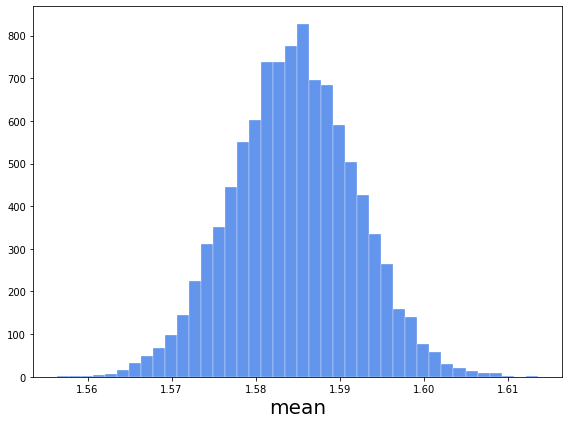

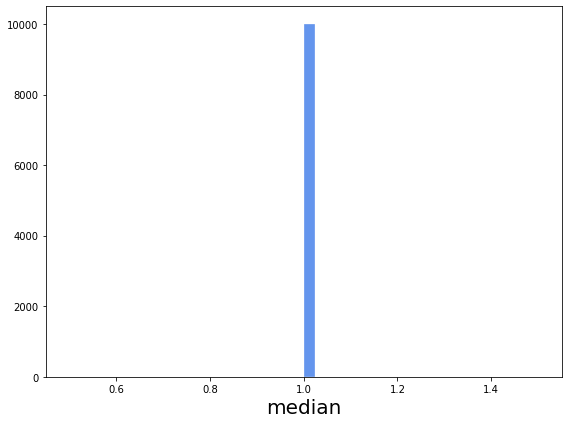

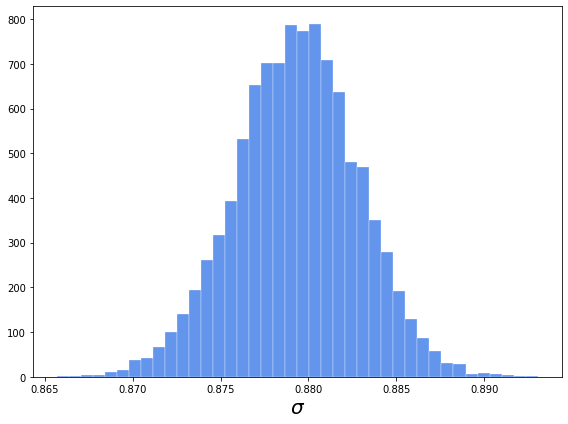

In [55]:
import statsmodels.stats.api as sms
import scipy.stats as st
from scipy.stats import sem, t

# Main feture to be plotted
main_feature = 'religion_dv'

# Select data of interest for a particular plot (that doesn't need table pivoting)
temp = data[[main_feature] + ['country_dv','surveyyear']]     

#Drop rows with nans
temp_nonan = temp.dropna(subset = [main_feature])
ans = temp_nonan[main_feature]

#calculate confidence intervals by several methods

#1
confidence = 0.95
n = len(temp_nonan[main_feature])
m = np.mean(temp_nonan[main_feature])
std_err = sem(temp_nonan[main_feature])
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h

#2
CI2 = sms.DescrStatsW(temp_nonan[main_feature]).tconfint_mean(alpha=0.05)

#3
CI3 = st.t.interval(0.95, len(temp_nonan[main_feature])-1, loc=np.mean(temp_nonan[main_feature]), scale=st.sem(temp_nonan[main_feature]))

print("CI1 =", start, end)
print("CI2 =", CI2)
print("CI3 =", CI3)

#bootstrap
R = 10000 #no. of bootstrapped samples
mean_all = []
median_all = []
std_all = []

for i in range(R):
    bs_sample = resample(temp_nonan[main_feature], replace=True, n_samples=len(temp_nonan), random_state=None)

    mean = np.mean(bs_sample)
    mean_all.append(mean)

    median = np.median(bs_sample)
    median_all.append(median)

    std = np.std(bs_sample)
    std_all.append(std)
    
#calculate sigma error from bootstrap
sig_err = np.std(mean_all)
two_sig_err = 2 * sig_err

print("1 sigma error = ", sig_err)
print("2 sigma error = ", two_sig_err)
print("Bootstrapped CI = ", np.mean(mean_all) - two_sig_err, np.mean(mean_all) + two_sig_err)

#Plot distributions

#plot example bootstrap sample
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(bs_sample, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('example sample', fontsize=20)
fig.tight_layout()

#plot mean distribution
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(mean_all, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('mean', fontsize=20)
fig.tight_layout()

#plot median distribution
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(median_all, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('median', fontsize=20)
fig.tight_layout()

#plot sigma distribution
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(std_all, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('$\\sigma$', fontsize=20)
fig.tight_layout()
plt.show()

plt.show()

Text(0.5, 0.9, '(D) Religion')

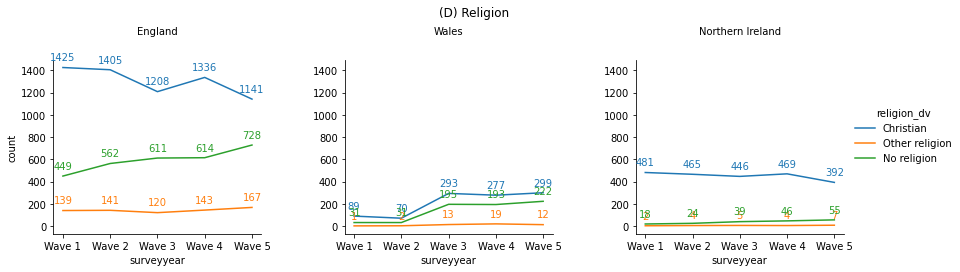

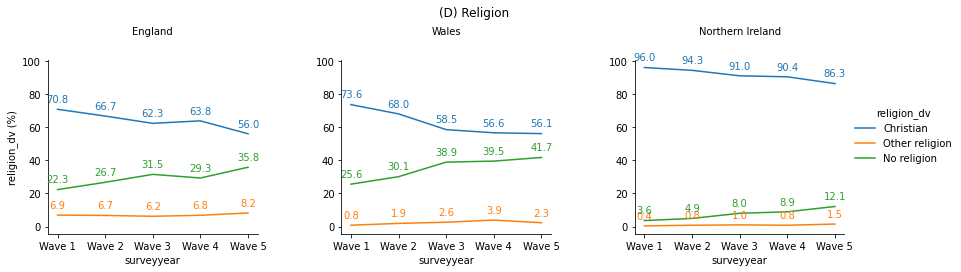

In [54]:
# Main feture to be plotted
main_feature = 'religion_dv'

# Select data of interest for a particular plot (that doesn't need table pivoting)
temp = data[[main_feature] + ['country_dv','surveyyear']] 

# Group according to the features of interest and calculate the % of answer types for the main target feature
temp = temp.groupby(['country_dv','surveyyear', main_feature])[main_feature].agg(['count'])                               

#############################################

# bootstrap code - under construction
# R = 1000 #no. of bootstrapped samples
# mean_all = []

# for i in range(R):
#     bs_sample = temp.sample(n =len(temp), replace=True, random_state=None)
#     mean = np.mean(bs_sample)
#     mean_all.append(mean)

# mean_all
 
# #calculate sigma error and confidence interval from bootstrap
# sig_err = np.std(mean_all)

# print(sig_err)
# bs_sample

# #plot mean distribution
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(1,1,1)
# plt.hist(mean_all, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
# plt.xlabel('mean', fontsize=20)
# fig.tight_layout()

# temp['up_error'] = error
# temp['down_error'] = error

#######################################

temp[main_feature + ' (%)'] = temp['count'] / temp.groupby(['country_dv','surveyyear'])['count'].sum() * 100
temp.reset_index(inplace=True) # To 'undo' the grouping
temp = temp.round(1)

# Recode the answers of those variables we want to use to stratify the population
answers_to_rename = ['country_dv', main_feature, 'surveyyear']
temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)

#temp
# Plot features of interest from the created 'temp' subset: COUNTS
g = sns.FacetGrid(temp, col='country_dv', hue=main_feature, height=4, aspect=1)
# g.map(errorbar, 'surveyyear', main_feature + ' (%)', 'up_error', 'down_error')
g = (g.map(f, 'surveyyear', 'count')
     .add_legend())
g.set_titles('{col_name}', pad = 25)
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
plt.figtext(.5,.9, questions_dict.get(main_feature), fontsize=12, ha='center') # Here we use dict, but without replace

# Plot features of interest from the created 'temp' subset: PERCENTAGES
g = sns.FacetGrid(temp, col='country_dv', hue=main_feature, height=4, aspect=1)
g = (g.map(f, 'surveyyear', main_feature + ' (%)')
     .add_legend())
g.set_titles('{col_name}', pad = 25)
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
plt.figtext(.5,.9, questions_dict.get(main_feature), fontsize=12, ha='center') # Here we use dict, but without replace